In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all datasets
try:
    customers = pd.read_csv(r"D:\data\internship\3\Task 9\olist_customers_dataset.csv")
    geolocation = pd.read_csv(r"D:\data\internship\3\Task 9\olist_geolocation_dataset.csv")
    order_items = pd.read_csv(r"D:\data\internship\3\Task 9\olist_order_items_dataset.csv")
    payments = pd.read_csv(r"D:\data\internship\3\Task 9\olist_order_payments_dataset.csv")
    reviews = pd.read_csv(r"D:\data\internship\3\Task 9\olist_order_reviews_dataset.csv")
    orders = pd.read_csv(r"D:\data\internship\3\Task 9\olist_orders_dataset.csv")
    products = pd.read_csv(r"D:\data\internship\3\Task 9\olist_products_dataset.csv")
    sellers = pd.read_csv(r"D:\data\internship\3\Task 9\olist_sellers_dataset.csv")
    translation = pd.read_csv(r"D:\data\internship\3\Task 9\product_category_name_translation.csv")
except FileNotFoundError:
    print("Ensure all Olist CSV files are in the directory.")
    # Exit gracefully if files are not found.
    exit()

In [2]:
# --- 1. Data Merging and Preprocessing ---

# Merge datasets into a single master DataFrame
df = orders.merge(customers, on='customer_id')
df = df.merge(reviews, on='order_id')
df = df.merge(order_items, on='order_id')
df = df.merge(payments, on='order_id')
df = df.merge(products, on='product_id')
df = df.merge(sellers, on='seller_id')
df = df.merge(translation, on='product_category_name', how='left')

# Convert date columns to datetime objects
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Feature Engineering: Create useful columns
# Calculate delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days
# Extract year-month for trend analysis
df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')

In [3]:
# --- 2. Exploratory Data Analysis (EDA) & Visualization ---

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

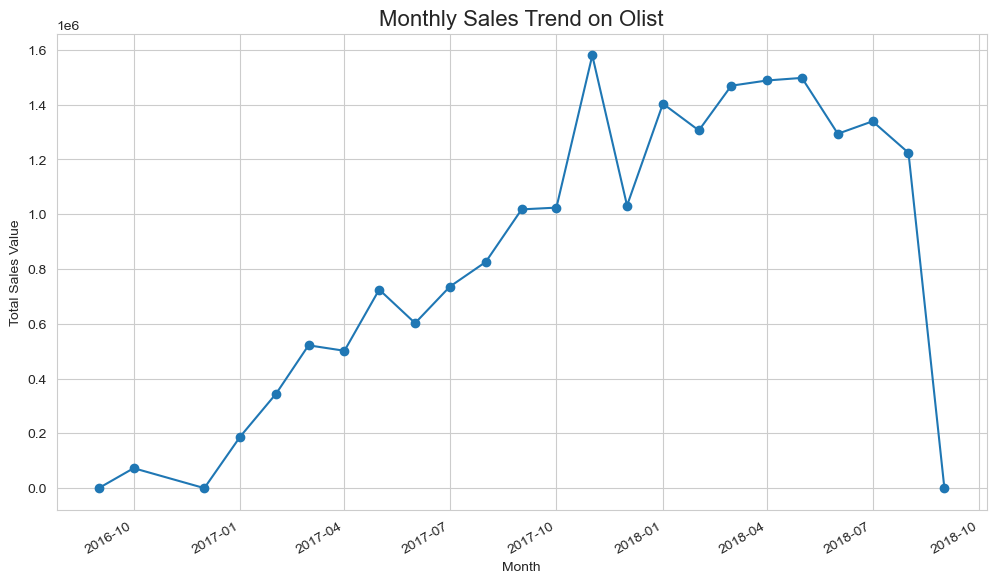

In [4]:
# a) Monthly Sales Trend
monthly_sales = df.groupby('purchase_month')['payment_value'].sum().to_timestamp()
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend on Olist', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales Value')
plt.show()

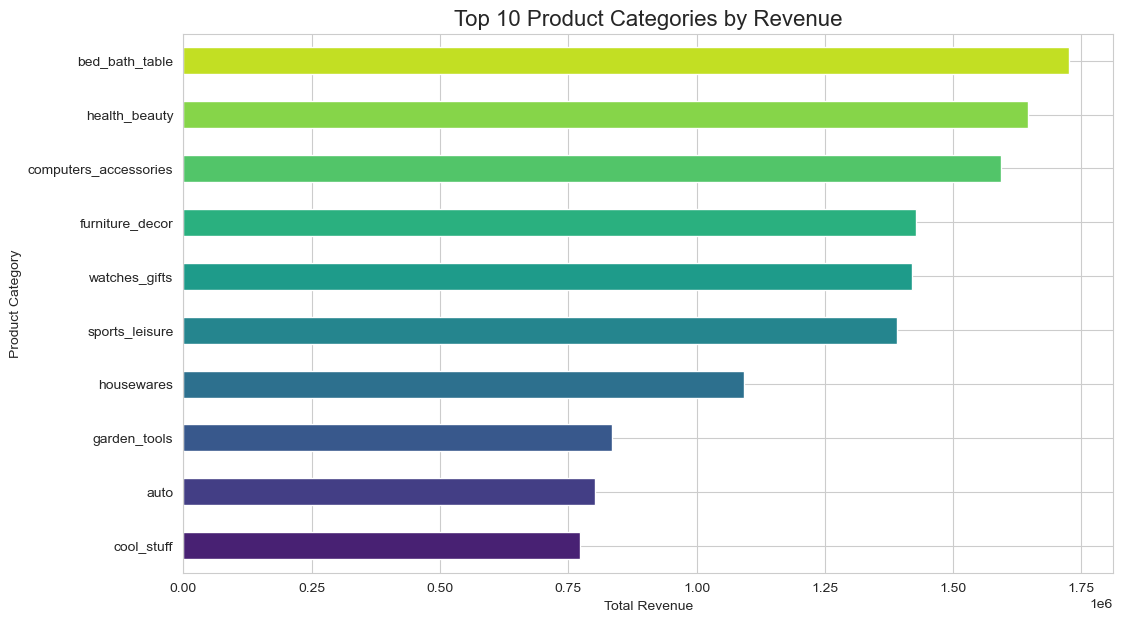

In [5]:
# b) Top 10 Product Categories by Sales
top_categories = df.groupby('product_category_name_english')['payment_value'].sum().nlargest(10).sort_values(ascending=True)
top_categories.plot(kind='barh', color=sns.color_palette('viridis', 10))
plt.title('Top 10 Product Categories by Revenue', fontsize=16)
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')
plt.show()

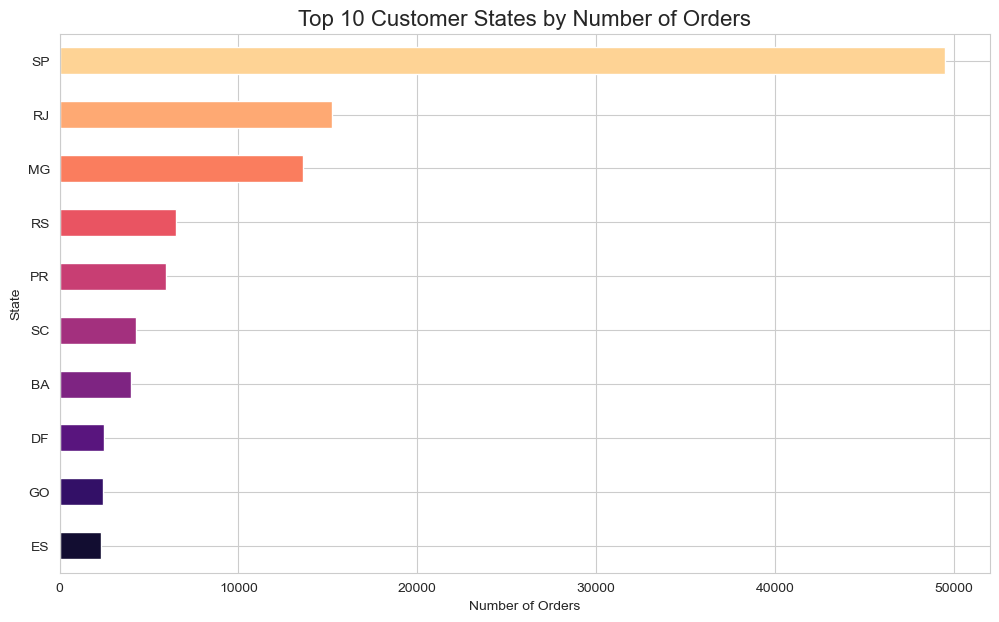

In [6]:
# c) Top 10 Customer States by Order Count
top_states = df['customer_state'].value_counts().nlargest(10).sort_values(ascending=True)
top_states.plot(kind='barh', color=sns.color_palette('magma', 10))
plt.title('Top 10 Customer States by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders')
plt.ylabel('State')
plt.show()

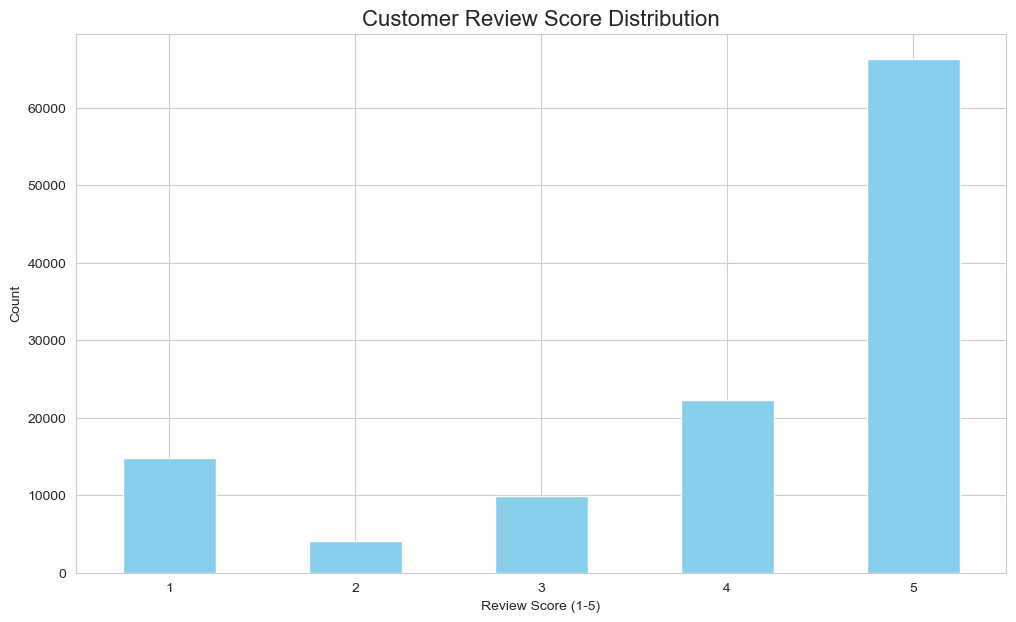

In [7]:
# d) Review Score Distribution
review_scores = df['review_score'].value_counts().sort_index()
review_scores.plot(kind='bar', color='skyblue')
plt.title('Customer Review Score Distribution', fontsize=16)
plt.xlabel('Review Score (1-5)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

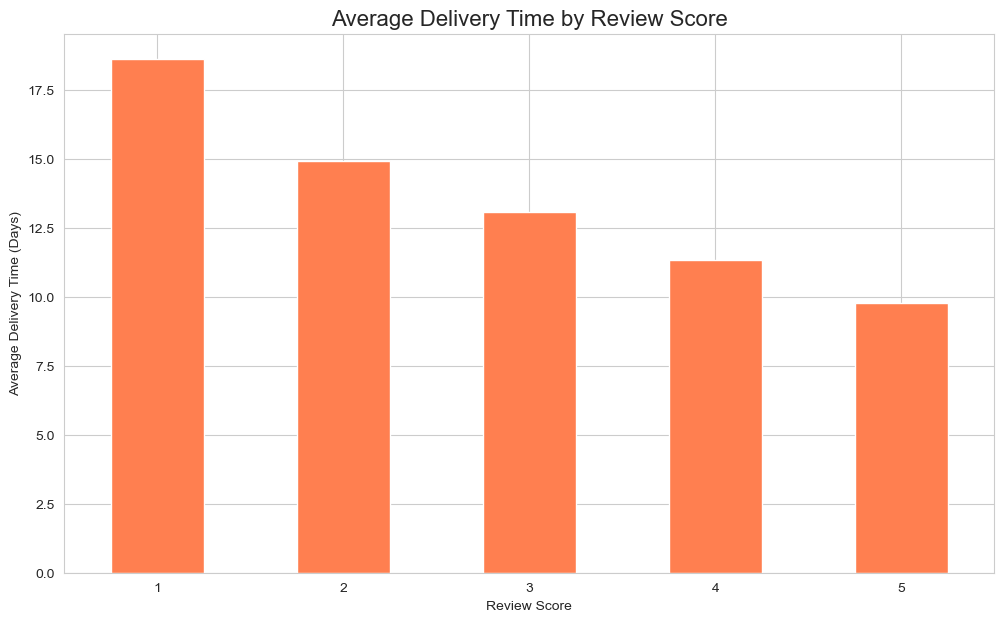

In [8]:
# e) Delivery Time vs. Review Score
delivery_vs_review = df.groupby('review_score')['delivery_time'].mean()
delivery_vs_review.plot(kind='bar', color='coral')
plt.title('Average Delivery Time by Review Score', fontsize=16)
plt.xlabel('Review Score')
plt.ylabel('Average Delivery Time (Days)')
plt.xticks(rotation=0)
plt.show()

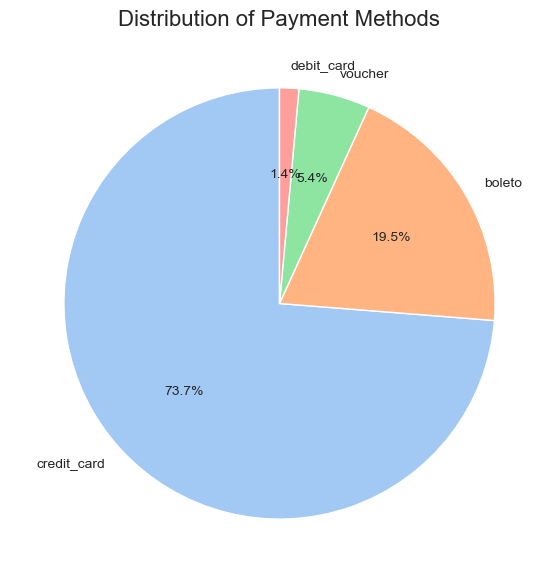

In [9]:
# f) Payment Method Distribution
payment_types = df['payment_type'].value_counts()
plt.pie(payment_types, labels=payment_types.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Payment Methods', fontsize=16)
plt.ylabel('')
plt.show()

In [10]:
# --- 3. Customer Segmentation (RFM Analysis) ---

# Keep only delivered orders for RFM
rfm_df = df[df['order_status'] == 'delivered'].copy()

# Set a snapshot date for recency calculation (day after the last purchase)
snapshot_date = rfm_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Calculate Recency, Frequency, Monetary values
rfm_data = rfm_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'payment_value': 'sum'
})
# Rename columns
rfm_data.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'Monetary'
}, inplace=True)

# Create RFM score quintiles (1-5, with 5 being the best)
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

# Define Segments
segment_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot Lose Them',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm_data['Segment'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str)
rfm_data['Segment'] = rfm_data['Segment'].replace(segment_map, regex=True)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_2200\1771829620.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='rocket')


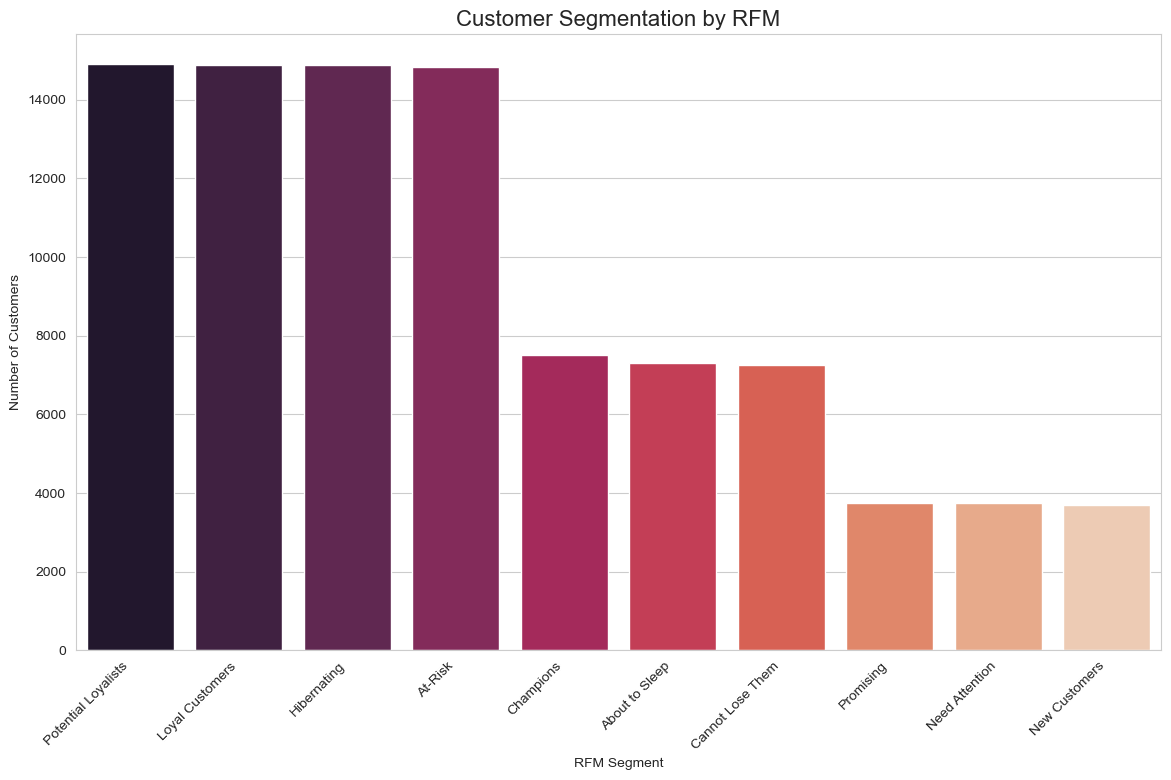

In [11]:
# Plot RFM Segments
segment_counts = rfm_data['Segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='rocket')
plt.title('Customer Segmentation by RFM', fontsize=16)
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
print("--- RFM Analysis Summary ---")
print(rfm_data['Segment'].value_counts())
print("\n--- One-time vs. Repeat Customers ---")
print(f"Percentage of one-time customers: { (rfm_data['Frequency'] == 1).mean() * 100 :.2f}%")

--- RFM Analysis Summary ---
Segment
Potential Loyalists    14917
Loyal Customers        14894
Hibernating            14880
At-Risk                14828
Champions               7501
About to Sleep          7311
Cannot Lose Them        7246
Promising               3739
Need Attention          3735
New Customers           3703
Name: count, dtype: int64

--- One-time vs. Repeat Customers ---
Percentage of one-time customers: 97.02%


## Detailed Findings and Visualizations
Here is a breakdown of the key findings from the analysis.

* ### 1. Sales Performance Over Time
The monthly sales data reveals a significant growth period for Olist, with a pronounced peak in sales in November 2017. This peak is likely associated with Black Friday, a key retail event. While sales stabilized in 2018, understanding the drivers of the 2017 growth is crucial for future marketing strategies.

* ### 2. Top Revenue-Generating Product Categories
The platform's revenue is heavily reliant on a few key categories. Bed Bath Table, Health Beauty, Sports Leisure, Furniture Decor, and Computers Accessories are the top 5 categories. Focusing marketing efforts and supply chain optimizations on these areas can yield the highest return on investment.

* ### 3. Geographic Customer Distribution
The customer base is geographically concentrated. The state of São Paulo (SP) dominates, representing a mature market. While this is a position of strength, it also indicates an opportunity to expand into other major states like Rio de Janeiro (RJ) and Minas Gerais (MG) to diversify the customer base and reduce dependency on a single region.

* ### 4. The Critical Link Between Delivery Time and Customer Satisfaction
While over 75% of reviews are positive (4 or 5 stars), a deeper analysis shows a clear and alarming trend: slow deliveries lead to bad reviews. 5-star reviews correspond to an average delivery time of just 9 days, whereas 1-star reviews are associated with an average of over 20 days. Improving logistics is the single most important action to take to enhance customer satisfaction.

* ### 5. Dominance of Credit Card Payments
Credit card is the preferred payment method for nearly 75% of all transactions. This indicates customer trust in the platform's payment security. The popularity of "boleto" (a Brazilian cash-based payment method) also highlights the need to support diverse payment options to cater to all customer segments.

* ### 6. RFM Customer Segmentation
RFM analysis provides a clear map of the customer base. While the number of "Champions" (most valuable customers) is smaller, they are crucial for long-term success. The large segments of "Hibernating" and "At-Risk" customers represent a significant, untapped opportunity. Targeted marketing campaigns are essential to re-engage these customers and guide "Potential Loyalists" toward becoming "Champions".